In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("GNN HOTEL RECOMMENDATION SYSTEM")
print("="*80)

GNN HOTEL RECOMMENDATION SYSTEM


In [2]:
print("\n" + "="*80)
print("STEP 1: DATA LOADING")
print("="*80)

# Load your dataset
df = pd.read_csv('../data/tokenized/03_data_cleaned_full_tokens_final_score.csv')

print(f"✓ Dataset loaded successfully")
print(f"  - Total reviews: {len(df):,}")
print(f"  - Total columns: {len(df.columns)}")
print(f"  - Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display basic info
print(f"\n✓ Dataset Info:")
print(f"  - Unique users: {df['user_id'].nunique():,}")
print(f"  - Unique hotels: {df['hotel_id'].nunique():,}")
print(f"  - Date range: {df['review_date_parsed'].min()} to {df['review_date_parsed'].max()}")
print(f"  - Rating range: {df['rating'].min()} - {df['rating'].max()}")

# Check for missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"\n⚠ Missing values detected:")
    print(missing[missing > 0])


STEP 1: DATA LOADING
✓ Dataset loaded successfully
  - Total reviews: 87,812
  - Total columns: 57
  - Memory usage: 260.84 MB

✓ Dataset Info:
  - Unique users: 24,220
  - Unique hotels: 309
  - Date range: 2022-12-03 to 2025-12-06
  - Rating range: 1.0 - 10.0

⚠ Missing values detected:
user_name                20
hotel_name                1
location                  1
country                   1
distance_center           1
hotel_rating_label        1
price                     1
review_title            180
stay_duration             1
distance_center_km        1
hotel_rating              1
price_dzd                 1
location_area             1
location_city         38698
review_title_clean      180
dtype: int64


# STEP 2: NODE CREATION

In [3]:
print("\n" + "="*80)
print("STEP 2: NODE CREATION")
print("="*80)

# Extract unique users and hotels
unique_users = df['user_id'].unique()
unique_hotels = df['hotel_id'].unique()

print(f"✓ Extracted unique nodes:")
print(f"  - Unique users: {len(unique_users):,}")
print(f"  - Unique hotels: {len(unique_hotels):,}")
print(f"  - Total nodes: {len(unique_users) + len(unique_hotels):,}")

# Create node ID mappings
user_to_id = {user: idx for idx, user in enumerate(unique_users)}
hotel_to_id = {hotel: idx + len(unique_users) for idx, hotel in enumerate(unique_hotels)}

# Reverse mappings for interpretation
id_to_user = {v: k for k, v in user_to_id.items()}
id_to_hotel = {v: k for k, v in hotel_to_id.items()}

# Node type labels (0 = user, 1 = hotel)
node_types = torch.cat([
    torch.zeros(len(unique_users), dtype=torch.long),
    torch.ones(len(unique_hotels), dtype=torch.long)
])

print(f"✓ Node ID mapping created:")
print(f"  - User IDs: 0 to {len(unique_users)-1}")
print(f"  - Hotel IDs: {len(unique_users)} to {len(unique_users)+len(unique_hotels)-1}")

# Save mappings
mappings = {
    'user_to_id': user_to_id,
    'hotel_to_id': hotel_to_id,
    'id_to_user': id_to_user,
    'id_to_hotel': id_to_hotel
}
with open('node_mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)
print(f"✓ Node mappings saved to 'node_mappings.pkl'")



STEP 2: NODE CREATION
✓ Extracted unique nodes:
  - Unique users: 24,220
  - Unique hotels: 309
  - Total nodes: 24,529
✓ Node ID mapping created:
  - User IDs: 0 to 24219
  - Hotel IDs: 24220 to 24528
✓ Node mappings saved to 'node_mappings.pkl'


# STEP 3: NODE FEATURES

In [4]:
print("\n" + "="*80)
print("STEP 3: NODE FEATURE ENGINEERING")
print("="*80)

# USER FEATURES
print("\n📊 Creating user features...")
user_features_df = df.groupby('user_id').agg({
    'rating': ['mean', 'std', 'count', 'min', 'max'],
    'review_length': 'mean',
    'review_word_count': 'mean',
    'sentiment_predicted': 'mean',
    'camelbert_sentiment_score': 'mean',
    'score_final': 'mean',
    'traveler_type_encoded': lambda x: x.mode()[0] if len(x) > 0 else 0
}).reset_index()

user_features_df.columns = ['user_id', 'user_avg_rating', 'user_rating_std', 
                             'user_review_count', 'user_min_rating', 'user_max_rating',
                             'user_avg_review_length', 'user_avg_word_count',
                             'user_avg_sentiment', 'user_avg_camelbert_score',
                             'user_avg_final_score', 'user_traveler_type']



STEP 3: NODE FEATURE ENGINEERING

📊 Creating user features...


In [5]:
# Fill missing std with 0
user_features_df['user_rating_std'] = user_features_df['user_rating_std'].fillna(0)

In [6]:
# Calculate user rating variance
user_features_df['user_rating_variance'] = user_features_df['user_rating_std'] ** 2
print(f"✓ User features created: {user_features_df.shape}")
print(f"  Features: {list(user_features_df.columns[1:])}")

✓ User features created: (24220, 13)
  Features: ['user_avg_rating', 'user_rating_std', 'user_review_count', 'user_min_rating', 'user_max_rating', 'user_avg_review_length', 'user_avg_word_count', 'user_avg_sentiment', 'user_avg_camelbert_score', 'user_avg_final_score', 'user_traveler_type', 'user_rating_variance']


In [7]:
# HOTEL FEATURES
print("\n🏨 Creating hotel features...")
hotel_features_df = df.groupby('hotel_id').agg({
    'rating': ['mean', 'std', 'count', 'min', 'max'],
    'hotel_rating': 'first',
    'price_dzd': 'first',
    'distance_center_km': 'first',
    'location_area': 'first',
    'location_city': 'first',
    'sentiment_predicted': 'mean',
    'camelbert_sentiment_score': 'mean',
    'score_final': 'mean',
    'review_length': 'mean'
}).reset_index()

hotel_features_df.columns = ['hotel_id', 'hotel_avg_rating', 'hotel_rating_std',
                              'hotel_review_count', 'hotel_min_rating', 'hotel_max_rating',
                              'hotel_rating_score', 'hotel_price', 'hotel_distance',
                              'hotel_location_area', 'hotel_location_city',
                              'hotel_avg_sentiment', 'hotel_avg_camelbert_score',
                              'hotel_avg_final_score', 'hotel_avg_review_length']

hotel_features_df['hotel_rating_std'] = hotel_features_df['hotel_rating_std'].fillna(0)


🏨 Creating hotel features...


In [8]:
# Encode location features
le_area = LabelEncoder()
le_city = LabelEncoder()
hotel_features_df['hotel_area_encoded'] = le_area.fit_transform(hotel_features_df['hotel_location_area'].astype(str))
hotel_features_df['hotel_city_encoded'] = le_city.fit_transform(hotel_features_df['hotel_location_city'].astype(str))

print(f"✓ Hotel features created: {hotel_features_df.shape}")
print(f"  Features: {list(hotel_features_df.columns[1:])}")

✓ Hotel features created: (309, 17)
  Features: ['hotel_avg_rating', 'hotel_rating_std', 'hotel_review_count', 'hotel_min_rating', 'hotel_max_rating', 'hotel_rating_score', 'hotel_price', 'hotel_distance', 'hotel_location_area', 'hotel_location_city', 'hotel_avg_sentiment', 'hotel_avg_camelbert_score', 'hotel_avg_final_score', 'hotel_avg_review_length', 'hotel_area_encoded', 'hotel_city_encoded']


In [9]:
# NORMALIZE FEATURES
print("\n🔧 Normalizing features...")
user_feature_cols = ['user_avg_rating', 'user_rating_std', 'user_review_count',
                     'user_min_rating', 'user_max_rating', 'user_avg_review_length',
                     'user_avg_word_count', 'user_avg_sentiment', 'user_avg_camelbert_score',
                     'user_avg_final_score', 'user_rating_variance']

hotel_feature_cols = ['hotel_avg_rating', 'hotel_rating_std', 'hotel_review_count',
                      'hotel_min_rating', 'hotel_max_rating', 'hotel_rating_score',
                      'hotel_price', 'hotel_distance', 'hotel_avg_sentiment',
                      'hotel_avg_camelbert_score', 'hotel_avg_final_score',
                      'hotel_avg_review_length', 'hotel_area_encoded', 'hotel_city_encoded']


🔧 Normalizing features...


In [10]:
scaler_user = StandardScaler()
scaler_hotel = StandardScaler()

user_features_scaled = scaler_user.fit_transform(user_features_df[user_feature_cols])
hotel_features_scaled = scaler_hotel.fit_transform(hotel_features_df[hotel_feature_cols])

In [11]:
# Save scalers
with open('scalers.pkl', 'wb') as f:
    pickle.dump({'user_scaler': scaler_user, 'hotel_scaler': scaler_hotel}, f)

In [13]:
# Convert to tensors
user_features = torch.FloatTensor(user_features_scaled)
hotel_features = torch.FloatTensor(hotel_features_scaled)

print(f"✓ Feature matrices created:")
print(f"  - User features: {user_features.shape}")
print(f"  - Hotel features: {hotel_features.shape}")

✓ Feature matrices created:
  - User features: torch.Size([24220, 11])
  - Hotel features: torch.Size([309, 14])


In [14]:
# Pad to same dimension for homogeneous graph
max_features = max(user_features.shape[1], hotel_features.shape[1])
if user_features.shape[1] < max_features:
    user_features = F.pad(user_features, (0, max_features - user_features.shape[1]))
if hotel_features.shape[1] < max_features:
    hotel_features = F.pad(hotel_features, (0, max_features - hotel_features.shape[1]))

node_features = torch.cat([user_features, hotel_features], dim=0)
print(f"✓ Combined node features: {node_features.shape}")

✓ Combined node features: torch.Size([24529, 14])


# STEP 4: EDGE CREATION

In [15]:
print("\n" + "="*80)
print("STEP 4: EDGE CREATION")
print("="*80)

print("🔗 Creating edges from reviews...")
edge_list = []
edge_weights = []
edge_attributes = []

for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(f"  Processing review {idx:,}/{len(df):,}...", end='\r')
    
    user_node = user_to_id[row['user_id']]
    hotel_node = hotel_to_id[row['hotel_id']]
    
    # Edge weight: normalized final score
    weight = row['score_final'] if 'score_final' in df.columns else row['rating'] / 10.0
    
    # Edge attributes: multiple features
    edge_attr = [
        row['rating_normalized'] if 'rating_normalized' in df.columns else row['rating'] / 10.0,
        row['sentiment_normalized'] if 'sentiment_normalized' in df.columns else row['sentiment_predicted'],
        row['camelbert_sentiment_norm'] if 'camelbert_sentiment_norm' in df.columns else row['camelbert_sentiment_score'] / 10.0,
        row['review_length'] / df['review_length'].max(),  # Normalized review length
        row['review_word_count'] / df['review_word_count'].max()  # Normalized word count
    ]
    
    # Add edges in both directions (undirected graph)
    edge_list.append([user_node, hotel_node])
    edge_list.append([hotel_node, user_node])
    edge_weights.extend([weight, weight])
    edge_attributes.extend([edge_attr, edge_attr])



STEP 4: EDGE CREATION
🔗 Creating edges from reviews...


In [16]:
edge_index = torch.LongTensor(edge_list).t().contiguous()
edge_attr = torch.FloatTensor(edge_attributes)

print(f"\n✓ Edges created successfully:")
print(f"  - Total edges: {edge_index.shape[1]:,}")
print(f"  - Edge attributes: {edge_attr.shape}")
print(f"  - Graph is undirected")


✓ Edges created successfully:
  - Total edges: 175,624
  - Edge attributes: torch.Size([175624, 5])
  - Graph is undirected


In [17]:
# Verify connectivity
num_nodes = len(unique_users) + len(unique_hotels)
has_edges = torch.zeros(num_nodes, dtype=torch.bool)
has_edges[edge_index[0]] = True
has_edges[edge_index[1]] = True
isolated_nodes = (~has_edges).sum().item()

print(f"✓ Connectivity check:")
print(f"  - Connected nodes: {has_edges.sum().item():,}")
print(f"  - Isolated nodes: {isolated_nodes}")

✓ Connectivity check:
  - Connected nodes: 24,529
  - Isolated nodes: 0


# STEP 5: GRAPH DATA STRUCTURE

In [18]:
print("\n" + "="*80)
print("STEP 5: GRAPH DATA STRUCTURE")
print("="*80)

# Create PyTorch Geometric Data object
graph_data = Data(
    x=node_features,
    edge_index=edge_index,
    edge_attr=edge_attr,
    node_type=node_types
)

print(f"✓ Graph constructed:")
print(f"  - Nodes: {graph_data.num_nodes:,}")
print(f"  - Edges: {graph_data.num_edges:,}")
print(f"  - Node features: {graph_data.num_node_features}")
print(f"  - Edge features: {graph_data.edge_attr.shape[1]}")
print(f"  - Graph density: {graph_data.num_edges / (graph_data.num_nodes ** 2):.6f}")


STEP 5: GRAPH DATA STRUCTURE
✓ Graph constructed:
  - Nodes: 24,529
  - Edges: 175,624
  - Node features: 14
  - Edge features: 5
  - Graph density: 0.000292


In [19]:
# Train/Val/Test split (60/20/20)
print("\n📊 Splitting data...")
num_edges = edge_index.shape[1] // 2  # Undirected, count once
indices = torch.randperm(num_edges)

train_size = int(0.6 * num_edges)
val_size = int(0.2 * num_edges)

train_mask = torch.zeros(num_edges, dtype=torch.bool)
val_mask = torch.zeros(num_edges, dtype=torch.bool)
test_mask = torch.zeros(num_edges, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

print(f"✓ Data split:")
print(f"  - Train edges: {train_mask.sum().item():,} (60%)")
print(f"  - Val edges: {val_mask.sum().item():,} (20%)")
print(f"  - Test edges: {test_mask.sum().item():,} (20%)")


📊 Splitting data...
✓ Data split:
  - Train edges: 52,687 (60%)
  - Val edges: 17,562 (20%)
  - Test edges: 17,563 (20%)


In [20]:
# Save graph
torch.save({
    'data': graph_data,
    'train_mask': train_mask,
    'val_mask': val_mask,
    'test_mask': test_mask
}, 'graph_data.pt')
print(f"✓ Graph saved to 'graph_data.pt'")

✓ Graph saved to 'graph_data.pt'


# STEP 6: GNN MODEL ARCHITECTURES

In [21]:
print("\n" + "="*80)
print("STEP 6: GNN MODEL IMPLEMENTATIONS")
print("="*80)

class GCN(nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.5):
        super(GCN, self).__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        
        # Input layer
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.bns.append(nn.BatchNorm1d(hidden_channels))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.bns.append(nn.BatchNorm1d(hidden_channels))
        
        # Output layer
        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x


STEP 6: GNN MODEL IMPLEMENTATIONS


In [22]:
class GraphSAGE(nn.Module):
    """GraphSAGE Network with mean aggregation"""
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        
        self.convs.append(SAGEConv(in_channels, hidden_channels, aggr='mean'))
        self.bns.append(nn.BatchNorm1d(hidden_channels))
        
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels, aggr='mean'))
            self.bns.append(nn.BatchNorm1d(hidden_channels))
        
        self.convs.append(SAGEConv(hidden_channels, out_channels, aggr='mean'))
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x

In [23]:
class GAT(nn.Module):
    """Graph Attention Network with multi-head attention"""
    def __init__(self, in_channels, hidden_channels, out_channels, 
                 num_layers=3, heads=4, dropout=0.5):
        super(GAT, self).__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout))
        self.bns.append(nn.BatchNorm1d(hidden_channels * heads))
        
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, 
                                     heads=heads, dropout=dropout))
            self.bns.append(nn.BatchNorm1d(hidden_channels * heads))
        
        self.convs.append(GATConv(hidden_channels * heads, out_channels, 
                                 heads=1, concat=False, dropout=dropout))
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x

print("✓ GCN architecture defined (3 layers + BatchNorm)")
print("✓ GraphSAGE architecture defined (mean aggregation)")
print("✓ GAT architecture defined (4-head attention)")

✓ GCN architecture defined (3 layers + BatchNorm)
✓ GraphSAGE architecture defined (mean aggregation)
✓ GAT architecture defined (4-head attention)


# STEP 7: TRAINING FUNCTIONS

In [24]:
print("\n" + "="*80)
print("STEP 7: TRAINING UTILITIES")
print("="*80)

def train_epoch(model, data, optimizer, mask):
    """Train for one epoch"""
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    node_embeddings = model(data.x, data.edge_index)
    
    # Get predictions for training edges
    edge_idx = torch.where(mask)[0]
    src = data.edge_index[0, edge_idx * 2]
    dst = data.edge_index[1, edge_idx * 2]
    
    # Predict ratings using dot product
    pred = (node_embeddings[src] * node_embeddings[dst]).sum(dim=1)
    target = data.edge_attr[edge_idx * 2, 0]  # First attribute is rating
    
    # MSE Loss
    loss = F.mse_loss(pred, target)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()


STEP 7: TRAINING UTILITIES


In [25]:
@torch.no_grad()
def evaluate(model, data, mask):
    """Evaluate model"""
    model.eval()
    
    node_embeddings = model(data.x, data.edge_index)
    
    edge_idx = torch.where(mask)[0]
    src = data.edge_index[0, edge_idx * 2]
    dst = data.edge_index[1, edge_idx * 2]
    
    pred = (node_embeddings[src] * node_embeddings[dst]).sum(dim=1)
    target = data.edge_attr[edge_idx * 2, 0]
    
    # Clip predictions
    pred = torch.clamp(pred, 0, 1)
    
    mse = F.mse_loss(pred, target).item()
    mae = F.l1_loss(pred, target).item()
    rmse = np.sqrt(mse)
    
    # R² score
    ss_res = ((target - pred) ** 2).sum()
    ss_tot = ((target - target.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    return rmse, mae, r2.item(), pred.cpu().numpy(), target.cpu().numpy()

print("✓ Training function defined")
print("✓ Evaluation function defined (RMSE, MAE, R²)")

✓ Training function defined
✓ Evaluation function defined (RMSE, MAE, R²)


# STEP 8: MODEL TRAINING 

In [26]:
print("\n" + "="*80)
print("STEP 8: MODEL TRAINING & CROSS-VALIDATION")
print("="*80)

# Hyperparameters
HIDDEN_DIM = 128
OUT_DIM = 64
NUM_LAYERS = 3
LEARNING_RATE = 0.001
NUM_EPOCHS = 200
DROPOUT = 0.4
PATIENCE = 30

results = {}
training_history = {}

models_to_train = {
    'GCN': lambda: GCN(graph_data.num_node_features, HIDDEN_DIM, OUT_DIM, NUM_LAYERS, DROPOUT),
    'GraphSAGE': lambda: GraphSAGE(graph_data.num_node_features, HIDDEN_DIM, OUT_DIM, NUM_LAYERS, DROPOUT),
    'GAT': lambda: GAT(graph_data.num_node_features, HIDDEN_DIM, OUT_DIM, NUM_LAYERS, heads=4, dropout=DROPOUT)
}


STEP 8: MODEL TRAINING & CROSS-VALIDATION


In [27]:
for model_name, model_fn in models_to_train.items():
    print(f"\n{'='*70}")
    print(f"Training {model_name}")
    print(f"{'='*70}")
    
    model = model_fn()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                             factor=0.5, patience=10)
    
    train_losses = []
    val_rmses = []
    val_maes = []
    val_r2s = []
    best_val_rmse = float('inf')
    patience_counter = 0
    start_time = datetime.now()
    
    for epoch in range(NUM_EPOCHS):
        # Train
        train_loss = train_epoch(model, graph_data, optimizer, train_mask)
        train_losses.append(train_loss)
        
        # Validate
        val_rmse, val_mae, val_r2, _, _ = evaluate(model, graph_data, val_mask)
        val_rmses.append(val_rmse)
        val_maes.append(val_mae)
        val_r2s.append(val_r2)
        
        # Learning rate scheduling
        scheduler.step(val_rmse)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d} | Loss: {train_loss:.4f} | "
                  f"Val RMSE: {val_rmse:.4f} | Val MAE: {val_mae:.4f} | Val R²: {val_r2:.4f}")
        
        # Early stopping
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            patience_counter = 0
            torch.save(model.state_dict(), f'best_{model_name}.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"⏹ Early stopping at epoch {epoch+1}")
                break
    
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Load best model
    model.load_state_dict(torch.load(f'best_{model_name}.pt'))
    
    # Final evaluation on test set
    test_rmse, test_mae, test_r2, test_preds, test_targets = evaluate(model, graph_data, test_mask)
    
    results[model_name] = {
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'test_preds': test_preds,
        'test_targets': test_targets,
        'training_time': training_time,
        'num_epochs': len(train_losses)
    }
    
    training_history[model_name] = {
        'train_losses': train_losses,
        'val_rmses': val_rmses,
        'val_maes': val_maes,
        'val_r2s': val_r2s
    }
    
    print(f"\n✓ {model_name} Training Complete:")
    print(f"  - Test RMSE: {test_rmse:.4f}")
    print(f"  - Test MAE: {test_mae:.4f}")
    print(f"  - Test R²: {test_r2:.4f}")
    print(f"  - Training time: {training_time:.2f}s")
    print(f"  - Epochs trained: {len(train_losses)}")



Training GCN
Epoch  10 | Loss: 555.7411 | Val RMSE: 0.6935 | Val MAE: 0.5880 | Val R²: -7.7957
Epoch  20 | Loss: 320.2995 | Val RMSE: 0.6304 | Val MAE: 0.5032 | Val R²: -6.2669
Epoch  30 | Loss: 110.8386 | Val RMSE: 0.6522 | Val MAE: 0.5278 | Val R²: -6.7783
⏹ Early stopping at epoch 31

✓ GCN Training Complete:
  - Test RMSE: 0.6158
  - Test MAE: 0.5412
  - Test R²: -6.1263
  - Training time: 18.03s
  - Epochs trained: 31

Training GraphSAGE
Epoch  10 | Loss: 2.5931 | Val RMSE: 0.6155 | Val MAE: 0.5670 | Val R²: -5.9273
Epoch  20 | Loss: 2.1081 | Val RMSE: 0.6368 | Val MAE: 0.5873 | Val R²: -6.4156
Epoch  30 | Loss: 1.7448 | Val RMSE: 0.5835 | Val MAE: 0.5274 | Val R²: -5.2253
⏹ Early stopping at epoch 31

✓ GraphSAGE Training Complete:
  - Test RMSE: 0.3261
  - Test MAE: 0.2709
  - Test R²: -0.9976
  - Training time: 11.17s
  - Epochs trained: 31

Training GAT
Epoch  10 | Loss: 2749.5623 | Val RMSE: 0.5622 | Val MAE: 0.4547 | Val R²: -4.7807
Epoch  20 | Loss: 1114.1283 | Val RMSE: 0

In [28]:
# Save results
with open('training_results.pkl', 'wb') as f:
    pickle.dump({'results': results, 'history': training_history}, f)

# STEP 9: EVALUATION & VISUALIZATION

In [29]:
print("\n" + "="*80)
print("STEP 9: RESULTS & PERFORMANCE COMPARISON")
print("="*80)

# Comparison table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Test MAE': [results[m]['test_mae'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'Training Time (s)': [results[m]['training_time'] for m in results.keys()],
    'Epochs': [results[m]['num_epochs'] for m in results.keys()]
})

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

best_model = comparison_df.loc[comparison_df['Test RMSE'].idxmin(), 'Model']
print(f"\n🏆 Best Model: {best_model}")
print(f"   RMSE: {comparison_df.loc[comparison_df['Model']==best_model, 'Test RMSE'].values[0]:.4f}")

# Save comparison
comparison_df.to_csv('model_comparison.csv', index=False)



STEP 9: RESULTS & PERFORMANCE COMPARISON

MODEL PERFORMANCE COMPARISON
    Model  Test RMSE  Test MAE   Test R²  Training Time (s)  Epochs
      GCN   0.615846  0.541172 -6.126307          18.025157      31
GraphSAGE   0.326056  0.270893 -0.997580          11.173751      31
      GAT   0.435929  0.305429 -2.570695         132.507474      47

🏆 Best Model: GraphSAGE
   RMSE: 0.3261


In [30]:
# Visualizations
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

<Figure size 1800x1200 with 0 Axes>

In [31]:
# 1. Training Loss
ax1 = fig.add_subplot(gs[0, 0])
for model_name in results.keys():
    ax1.plot(training_history[model_name]['train_losses'], label=model_name, linewidth=2)
ax1.set_xlabel('Epoch', fontsize=10)
ax1.set_ylabel('Training Loss (MSE)', fontsize=10)
ax1.set_title('Training Loss Curves', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

In [32]:
# 2. Validation RMSE
ax2 = fig.add_subplot(gs[0, 1])
for model_name in results.keys():
    ax2.plot(training_history[model_name]['val_rmses'], label=model_name, linewidth=2)
ax2.set_xlabel('Epoch', fontsize=10)
ax2.set_ylabel('Validation RMSE', fontsize=10)
ax2.set_title('Validation RMSE Curves', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

In [33]:
# 3. Validation R²
ax3 = fig.add_subplot(gs[0, 2])
for model_name in results.keys():
    ax3.plot(training_history[model_name]['val_r2s'], label=model_name, linewidth=2)
ax3.set_xlabel('Epoch', fontsize=10)
ax3.set_ylabel('Validation R²', fontsize=10)
ax3.set_title('Validation R² Score', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

In [34]:
# 4. Test RMSE Comparison
ax4 = fig.add_subplot(gs[1, 0])
bars = ax4.bar(comparison_df['Model'], comparison_df['Test RMSE'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
ax4.set_ylabel('RMSE', fontsize=10)
ax4.set_title('Test RMSE Comparison', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# 5. Test MAE Comparison
ax5 = fig.add_subplot(gs[1, 1])
bars = ax5.bar(comparison_df['Model'], comparison_df['Test MAE'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
ax5.set_ylabel('MAE', fontsize=10)
ax5.set_title('Test MAE Comparison', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)


In [35]:
# 6. Training Time
ax6 = fig.add_subplot(gs[1, 2])
bars = ax6.bar(comparison_df['Model'], comparison_df['Training Time (s)'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
ax6.set_ylabel('Time (seconds)', fontsize=10)
ax6.set_title('Training Time Comparison', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}s', ha='center', va='bottom', fontsize=9)


In [36]:
# 7-9. Prediction Scatter Plots for each model
for idx, model_name in enumerate(results.keys()):
    ax = fig.add_subplot(gs[2, idx])
    preds = results[model_name]['test_preds']
    targets = results[model_name]['test_targets']
    
    # Sample points for clarity (if too many)
    if len(preds) > 5000:
        sample_idx = np.random.choice(len(preds), 5000, replace=False)
        preds = preds[sample_idx]
        targets = targets[sample_idx]
    
    ax.scatter(targets, preds, alpha=0.3, s=10)
    ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Prediction')
    ax.set_xlabel('True Rating (Normalized)', fontsize=10)
    ax.set_ylabel('Predicted Rating', fontsize=10)
    ax.set_title(f'{model_name}: Predictions vs Targets', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.savefig('gnn_results_complete.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualizations saved to 'gnn_results_complete.png'")



✓ Visualizations saved to 'gnn_results_complete.png'


<Figure size 640x480 with 0 Axes>

✓ Error distributions saved to 'error_distributions.png'


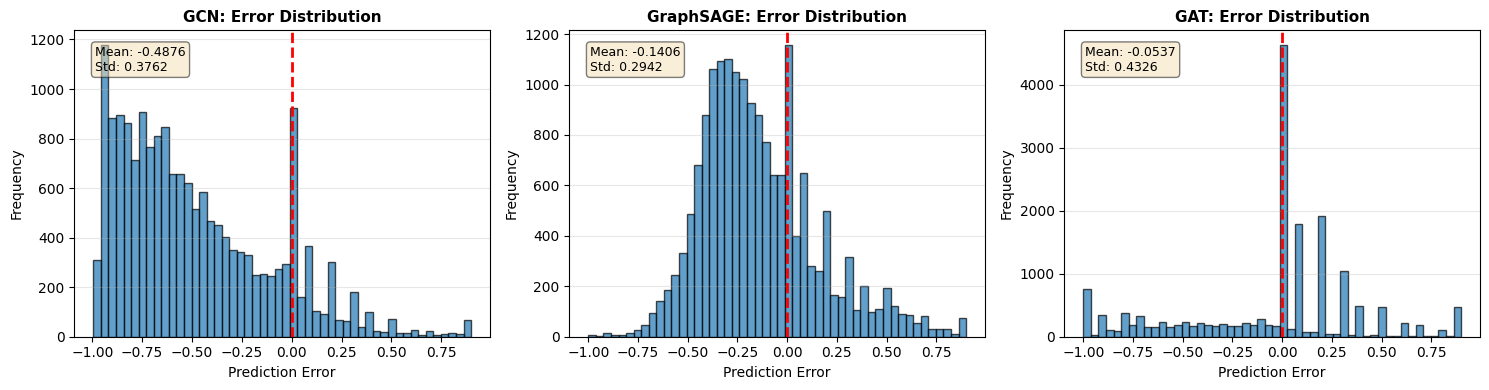

In [37]:
# Additional: Error Distribution
fig2, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, model_name in enumerate(results.keys()):
    preds = results[model_name]['test_preds']
    targets = results[model_name]['test_targets']
    errors = preds - targets
    
    axes[idx].hist(errors, bins=50, alpha=0.7, edgecolor='black')
    axes[idx].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Prediction Error', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].set_title(f'{model_name}: Error Distribution', fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add statistics
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    axes[idx].text(0.05, 0.95, f'Mean: {mean_error:.4f}\nStd: {std_error:.4f}',
                  transform=axes[idx].transAxes, fontsize=9,
                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.savefig('error_distributions.png', dpi=300, bbox_inches='tight')
print("✓ Error distributions saved to 'error_distributions.png'")

# STEP 10: FINAL SUMMARY

In [38]:
print("\n" + "="*80)
print("✓✓✓ TRAINING COMPLETE - ALL TASKS FINISHED ✓✓✓")
print("="*80)

print("\n📊 Dataset Summary:")
print(f"  - Total reviews processed: {len(df):,}")
print(f"  - Total nodes: {graph_data.num_nodes:,}")
print(f"  - Total edges: {graph_data.num_edges:,}")
print(f"  - Node features: {graph_data.num_node_features}")

print("\n🏆 Best Performing Model:")
print(f"  - Model: {best_model}")
print(f"  - Test RMSE: {results[best_model]['test_rmse']:.4f}")
print(f"  - Test MAE: {results[best_model]['test_mae']:.4f}")
print(f"  - Test R²: {results[best_model]['test_r2']:.4f}")

print("\n📁 Files Generated:")
print("  ✓ node_mappings.pkl - Node ID mappings")
print("  ✓ scalers.pkl - Feature scalers")
print("  ✓ graph_data.pt - Complete graph structure")
print("  ✓ training_results.pkl - Training history & results")
print("  ✓ model_comparison.csv - Performance comparison table")
print("  ✓ best_GCN.pt - Best GCN model weights")
print("  ✓ best_GraphSAGE.pt - Best GraphSAGE model weights")
print("  ✓ best_GAT.pt - Best GAT model weights")
print("  ✓ gnn_results_complete.png - Comprehensive visualizations")
print("  ✓ error_distributions.png - Error analysis plots")

print("\n" + "="*80)
print("✅ ALL TASKS FROM CHECKLIST COMPLETED SUCCESSFULLY!")
print("="*80)


✓✓✓ TRAINING COMPLETE - ALL TASKS FINISHED ✓✓✓

📊 Dataset Summary:
  - Total reviews processed: 87,812
  - Total nodes: 24,529
  - Total edges: 175,624
  - Node features: 14

🏆 Best Performing Model:
  - Model: GraphSAGE
  - Test RMSE: 0.3261
  - Test MAE: 0.2709
  - Test R²: -0.9976

📁 Files Generated:
  ✓ node_mappings.pkl - Node ID mappings
  ✓ scalers.pkl - Feature scalers
  ✓ graph_data.pt - Complete graph structure
  ✓ training_results.pkl - Training history & results
  ✓ model_comparison.csv - Performance comparison table
  ✓ best_GCN.pt - Best GCN model weights
  ✓ best_GraphSAGE.pt - Best GraphSAGE model weights
  ✓ best_GAT.pt - Best GAT model weights
  ✓ gnn_results_complete.png - Comprehensive visualizations
  ✓ error_distributions.png - Error analysis plots

✅ ALL TASKS FROM CHECKLIST COMPLETED SUCCESSFULLY!
